In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys
import librosa, librosa.display 

p = os.path.abspath('../') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.2  Device :  cuda


In [2]:
import torchaudio
import torchaudio.transforms as T

In [3]:
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.
FIG_SIZE = (15,10)

In [4]:
train_df=pd.read_csv("D:/dacon/covid19/data/train_data.csv")
test_df=pd.read_csv("D:/dacon/covid19/data/test_data.csv")


In [5]:
#load
import pickle
with open("D:/dacon/covid19/data/pickles/train_dict.pickle","rb") as fr:
    train_dict = pickle.load(fr)



# train/valid 나누기 (stratified kfold)

In [6]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


healthy = list(train_df[train_df['covid19']==0]['id'])
covid = list(train_df[train_df['covid19']==1]['id'])
print("Healthy : ",len(healthy))
print("Covid: ",len(covid))

X = healthy+covid # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<3499:
        Y.append("healthy")
    else:
        Y.append("covid")

Healthy :  3499
Covid:  306
총 데이터수 :  3805


In [7]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'covid': 245, 'healthy': 2799}
검증 레이블 데이터 분포 : 
 {'covid': 61, 'healthy': 700} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'covid': 245, 'healthy': 2799}
검증 레이블 데이터 분포 : 
 {'covid': 61, 'healthy': 700} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'covid': 245, 'healthy': 2799}
검증 레이블 데이터 분포 : 
 {'covid': 61, 'healthy': 700} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'covid': 245, 'healthy': 2799}
검증 레이블 데이터 분포 : 
 {'covid': 61, 'healthy': 700} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'covid': 244, 'healthy': 2800}
검증 레이블 데이터 분포 : 
 {'covid': 62, 'healthy': 699} 



랜덤 오버 샘플링

In [8]:
#2. random over sampling

for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )   
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res


'\nfor i in range(5):\n    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)\n    #Y = np.array(Y)\n    ros = RandomOverSampler(random_state = 123)\n    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])\n    \n    print("\n fold{} ".format(i))\n    print(\'before dataset shape {}\'.format(Counter(Y_train_list[i])) )\n    print(\'Resampled dataset shape {}\'.format(Counter(Y_res)) )   \n    \n    #원래대로 돌리기\n    X_res=X_res.reshape(1, -1)\n    X_train_list[i]=X_res[0].tolist()\n    Y_train_list[i]=Y_res\n\n'

# data loader

In [1]:
from torch.utils.data import Dataset, DataLoader

classes = ["healthy","covid"]
sr=16000
win_length =  np.int64(sr/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.


class covid_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None,augment=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = covid_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        self.augment=augment
        self.normalize=normalize
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        num = self.path_list[idx]
        num_str = str(num)   
        sig = train_dict[num_str.zfill(5)+'.wav']
        length_of_sig = sig.shape[0]
        
        length=243840 #300 padding을 위한 파라미터
        pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###        
        
        
        
        MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=21)
        
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)        
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)        
        log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절        
        
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화
            MSF = torch.stack([log_spectrogram,mel_feature,MFCCs])# 3채널로 복사.
            if self.training:
                MSF=self.augment(MSF)
            MSF = MSF.squeeze(dim=1)
            # global normalize
            if self.normalize:
                MSF=self.normalize(MSF)
            
        else:
            #print("else")
            # 사용안함.
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF, self.classes.index(self.label[idx])
    

NameError: name 'np' is not defined

In [10]:
#3. 하이퍼 파라미터
BATCH_SIZE =  32 #한 배치당 16개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복

In [11]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           covid_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정. to tensor는 -데이터는 노멀라이즈못함.
                                               data_num=0,
                                               training=True,
                                               augment = transforms.Compose([
                                                   T.TimeMasking(time_mask_param=120),
                                                   T.FrequencyMasking(freq_mask_param=13)
                                               ]),
                                               normalize=transforms.Normalize((-13.326587 , -69.00234,-2.653834), (14.9956,15.334582,32.017303)),
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           covid_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               normalize=transforms.Normalize((-13.326587 , -69.00234,-2.653834), (14.9956,15.334582,32.017303)),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



# 데이터 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X_train :  torch.Size([32, 3, 128, 2439]) type: torch.FloatTensor
Y_train :  torch.Size([32]) type: torch.LongTensor
healthy


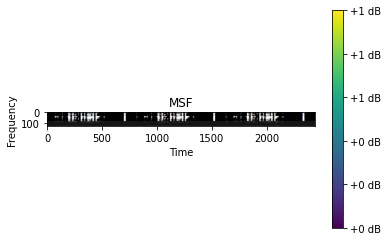

In [12]:
# 4. 데이터 확인하기
for (X_train,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'type:',X_train.type())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(classes[Y_train[0]])
plt.imshow(X_train[0].view(128,-1,3).numpy())
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("MSF")
plt.show()
#batch: 32 / 3채널 / frame수: 500  /  feature수: 1

X_valid :  torch.Size([32, 3, 128, 2439]) type: torch.FloatTensor
Y_valid :  torch.Size([32]) type: torch.LongTensor
healthy


Text(0.5, 1.0, 'Spectrogram (dB)')

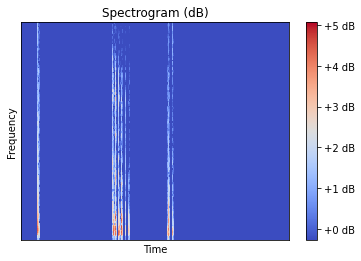

In [13]:
#valiation set 확인
for (X_valid,Y_valid) in validation_loader:
    print("X_valid : ",X_valid.size(),'type:',X_valid.type())
    print("Y_valid : ",Y_valid.size(),'type:',Y_valid.type())
    break

print(classes[Y_valid[0]])
librosa.display.specshow(X_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram (dB)")

#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

# 모델

In [14]:
class ResLayer(nn.Module):
    def __init__(self):
        super(ResLayer, self).__init__()
        self.model = models.resnet18(pretrained=True).cuda()
        
        self.model.ftrs = self.model.fc.in_features # in_features : fully connected의 입력수.
        self.num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Sequential(nn.Linear(self.num_ftrs, 64),
                             nn.BatchNorm1d(64),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(64,50),
                             nn.BatchNorm1d(50),
                             nn.ReLU(),
                             nn.Dropout(p=0.5),
                             nn.Linear(50,2)
                            )
        

    def forward(self, x):
        res_feature=self.model(x)
        return res_feature



def model_initialize():
    model = ResLayer().cuda()
    #model=se_resnet18().cuda()
    return model

model=model_initialize()

In [15]:
# 여기는 반영 안됨.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
print(model)

ResLayer(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [16]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(image) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [17]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
from sklearn.metrics import f1_score

def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in valid_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [18]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               covid_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True,
                                                   normalize=transforms.Normalize((-13.326587 , -69.00234,-2.653834), (14.9956,15.334582,32.017303)),
                                                   augment = transforms.Compose([
                                                       T.TimeMasking(time_mask_param=240),
                                                       T.FrequencyMasking(freq_mask_param=13)
                                               ]),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               covid_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   normalize=transforms.Normalize((-13.326587 , -69.00234,-2.653834), (14.9956,15.334582,32.017303)),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [19]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = './checkpoint/checkpoint_MSF_resnet18_true_pos_'+str(data_ind)+'.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
            
            


./checkpoint/checkpoint_MSF_resnet18_true_pos_1.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0250	 Train Acc:49.15 %  | 	Valid Loss:0.0218 	Valid Acc: 71.48 %

Validation loss decreased (inf --> 0.021800).  Saving model ...

[EPOCH:2]	 Train Loss:0.0228	 Train Acc:57.59 %  | 	Valid Loss:0.0218 	Valid Acc: 80.16 %

Validation loss decreased (0.021800 --> 0.021773).  Saving model ...

[EPOCH:3]	 Train Loss:0.0227	 Train Acc:67.54 %  | 	Valid Loss:0.0216 	Valid Acc: 91.98 %

Validation loss decreased (0.021773 --> 0.021552).  Saving model ...

[EPOCH:4]	 Train Loss:0.0229	 Train Acc:71.25 %  | 	Valid Loss:0.0219 	Valid Acc: 91.98 %

EarlyStopping counter: 1 out of 5

[EPOCH:5]	 Train Loss:0.0228	 Train Acc:70.47 %  | 	Valid Loss:0.0218 	Valid Acc: 91.98 %

EarlyStopping counter: 2 out of 5

[EPOCH:6]	 Train Loss:0.0219	 Train Acc:67.87 %  | 	Valid Loss:0.0217 	Valid Acc: 91.98 %

EarlyStopping counter: 3 out of 5

[EPOCH:7]	 Train Loss:0.0222	 Train Acc:75.13 %  | 	Valid Loss:0.0215


[EPOCH:6]	 Train Loss:0.0221	 Train Acc:64.49 %  | 	Valid Loss:0.0218 	Valid Acc: 91.85 %

EarlyStopping counter: 2 out of 5

[EPOCH:7]	 Train Loss:0.0219	 Train Acc:77.99 %  | 	Valid Loss:0.0218 	Valid Acc: 91.85 %

EarlyStopping counter: 3 out of 5

[EPOCH:8]	 Train Loss:0.0218	 Train Acc:81.87 %  | 	Valid Loss:0.0218 	Valid Acc: 91.85 %

EarlyStopping counter: 4 out of 5

[EPOCH:9]	 Train Loss:0.0222	 Train Acc:82.06 %  | 	Valid Loss:0.0217 	Valid Acc: 91.85 %

Validation loss decreased (0.021757 --> 0.021709).  Saving model ...

[EPOCH:10]	 Train Loss:0.0221	 Train Acc:82.88 %  | 	Valid Loss:0.0218 	Valid Acc: 91.85 %

EarlyStopping counter: 1 out of 5

[EPOCH:11]	 Train Loss:0.0219	 Train Acc:85.12 %  | 	Valid Loss:0.0219 	Valid Acc: 91.85 %

EarlyStopping counter: 2 out of 5

[EPOCH:12]	 Train Loss:0.0220	 Train Acc:85.68 %  | 	Valid Loss:0.0218 	Valid Acc: 91.85 %

EarlyStopping counter: 3 out of 5

[EPOCH:13]	 Train Loss:0.0216	 Train Acc:87.22 %  | 	Valid Loss:0.0218 	Valid A

# 모델 결과 확인

In [20]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

[1 교차검증] train ACC : 75.1314 |	 valid ACC: 91.9842 
[2 교차검증] train ACC : 75.7884 |	 valid ACC: 91.9842 
[3 교차검증] train ACC : 84.9212 |	 valid ACC: 91.9842 
[4 교차검증] train ACC : 76.3141 |	 valid ACC: 91.9842 
[5 교차검증] train ACC : 82.0631 |	 valid ACC: 91.8528 
평균 검증 정확도 91.95795006570302 %


# TEST 확인

In [21]:
X_test=list(test_df['id'] )

In [22]:
with open("D:/dacon/covid19/data/pickles/test_dict.pickle","rb") as fr:
    test_dict = pickle.load(fr)

In [27]:
# test set 제작을 위한 class
classes = ["healthy","covid"]
sr=16000
win_length =  np.int64(sr/40) # 400
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

class covid_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None,normalize=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.classes=classes
        self.transform=transform
        self.normalize=normalize
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 224프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        num = self.path_list[idx]
        num_str = str(num)   
        sig = test_dict[num_str.zfill(5)+'.wav']
        length_of_sig = sig.shape[0]
        
        length=243840 #300 padding을 위한 파라미터
        pad1d=lambda a, i: a[0:i] if a.shape[0] > i else np.hstack((a, np.zeros((i-a.shape[0]))))        
        sig = pad1d(sig,length)        
        
        ###signal norm
        sig = (sig-sig.mean())/sig.std()
        ###        
        
        
        
        MFCCs = librosa.feature.mfcc(y=sig, sr=sr,win_length=win_length ,n_fft=n_fft, hop_length=hop_length, n_mfcc=128)
        
        
        stft = librosa.stft(sig, win_length=win_length,n_fft=n_fft, hop_length=hop_length)        
        magnitude = np.abs(stft)
        log_spectrogram = librosa.amplitude_to_db(magnitude)        
        log_spectrogram=log_spectrogram[:128,:]# 224 x 300 으로 사이즈 조절        
        
        mel_feature = librosa.feature.melspectrogram(y=sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
        mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
        #mel_feature=librosa.util.normalize(mel_feature) # l-infinity norm
        
        
        if self.transform:
            #print('transform')
            log_spectrogram=self.transform(log_spectrogram).type(torch.float32)# 타입 변화
            mel_feature=self.transform(mel_feature).type(torch.float32)
            MFCCs=self.transform(MFCCs).type(torch.float32)# 타입 변화
            MSF = torch.stack([log_spectrogram,mel_feature,MFCCs])# 3채널로 복사.
            if self.training:
                MSF=self.augment(MSF)
            MSF = MSF.squeeze(dim=1)
            # global normalize
            if self.normalize:
                MSF=self.normalize(MSF)
            
        else:
            #print("else")
            # 사용안함.
            mel_feature = torch.from_numpy(mel_feature).type(torch.float32)
            mel_feature=mel_feature.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return MSF,num
    
    

In [28]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               covid_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   normalize=transforms.Normalize((-13.326587 , -69.00234,-2.653834), (14.9956,15.334582,32.017303)),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = False,) 

In [29]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    num_list = []
    predictions = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image,num in test_loader:
            image = image.to(DEVICE)
            output = model(image)
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            predictions +=prediction
            num_list += num
            
        return predictions,num_list
            

In [30]:
sample_prediction = pd.read_csv("D:/dacon/covid19/data/sample_submission.csv")

In [31]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.


for data_ind in range(1,6):
    
    check_path = './checkpoint/checkpoint_MSF_resnet18_true_ros_'+str(data_ind)+'.pt'
    model.load_state_dict(torch.load(check_path))

    predictions, num_list = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    sample_prediction['covid19'] = [dat.item() for dat in predictions]
    file_name = "D:/dacon/covid19/"+str(data_ind)+"_result.csv"
    sample_prediction.to_csv(file_name,index=False)
    




AttributeError: 


- 0619
1. 나이, 병 유무 데이터 넣어서 다시 학습하기.
2. specaugment 추가하기.
3. random oversampling
4. 시간되면, 배치별로 패딩으로 수정하기.